In [72]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from math import pi
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1. Read data

In [73]:
# studies
db_studies = pd.read_csv('02data_extraction/literatures.csv')

# models
db_models = pd.read_csv('02data_extraction/models.csv')

# 2. Data preprocessing

In [74]:
# 1.1 time span
# db_studies
db_studies['time_start'] = db_studies['time_start'].apply(str)
db_studies['time_start'] = db_studies['time_start'].apply(lambda x: np.nan if x=='not mentioned' else (pd.to_datetime(x,format='%Y') if len(x) == 4 else(pd.to_datetime(x) if 'q' in x else pd.to_datetime(x,format='%Y%m'))))

db_studies['time_end'] = db_studies['time_end'].apply(str)
db_studies['time_end'] = db_studies['time_end'].apply(lambda x: np.nan if x=='not mentioned' else (pd.to_datetime(x+'12',format='%Y%m') if len(x) == 4 else(pd.to_datetime(x) if 'q' in x else pd.to_datetime(x,format='%Y%m'))))

db_studies['time_span_cal'] = db_studies['time_end'] - db_studies['time_start']

db_studies['data_ht_1'] = db_studies['data_ht_1'].apply(lambda x: 'All' if x=='all ' else ('Apartment' if x == 'apartment' else 'House'))

# db_models
# Change data type
db_models['time_start'] = db_models['time_start'].apply(str)
db_models['time_start'] = db_models['time_start'].apply(lambda x: np.nan if x=='not mentioned' else (pd.to_datetime(x,format='%Y') if len(x) == 4 else(pd.to_datetime(x) if 'q' in x else pd.to_datetime(x,format='%Y%m'))))

db_models['time_end'] = db_models['time_end'].apply(str)
db_models['time_end'] = db_models['time_end'].apply(lambda x: np.nan if x=='not mentioned' else (pd.to_datetime(x+'12',format='%Y%m') if len(x) == 4 else(pd.to_datetime(x) if 'q' in x else pd.to_datetime(x,format='%Y%m'))))

db_models['data_ht_1'] = db_models['data_ht_1'].apply(lambda x: 'All' if x=='all ' else ('Apartment' if x == 'apartment' else 'House'))

db_models['data_tenure'] = db_models['data_tenure'].apply(lambda x: 'Sales' if x=='sales' else ('Rents' if x == 'rents' else 'both'))

In [75]:
# Calculate categorical values for time span
# filter data
time_table = db_studies.drop_duplicates(subset=['paper_id','time_start','time_end'],keep='first')

# drop null rows
time_table = time_table.dropna(subset=['paper_id','time_start','time_end'])

# transform time span into years
time_table['time_span_cal'] = time_table['time_span_cal'].apply(lambda x: int(str(x)[:-13])/365)

# transform time span into categorical values
# <= 1 year, 1-3 years, 3-5 years, 5-10 years, >10 years
time_table['time_span_cat'] = time_table['time_span_cal'].apply(lambda x: '<= 1 year' if x<=1 else '1-3 years' if x<=3 else '3-5 years' if x<=5 else '5-10 years' if x<=10 else '>10 years')

# copy column to db_studies dataframe
time_table = time_table[['paper_id','time_span_cat']]
db_studies = pd.merge(db_studies, time_table, on="paper_id", how="left")

In [76]:
# 1.2 Sample size
# Transform into numerical values
# <1,000, 1,000-9,999, 10,000-99,999, 100,000-999,999, >=1,000,000
db_studies[["data_sample_size"]] = db_studies[["data_sample_size"]].replace("not applicable", np.nan)
db_studies[["data_sample_size"]] = db_studies[["data_sample_size"]].replace("over 5 million", 5000000)
db_studies[["data_sample_size"]] = db_studies[["data_sample_size"]].apply(pd.to_numeric)

# 3. Research scope and scale

## 3.1 Count numerical values (data sample size)

In [77]:
# Count by ranges
ranges = [0,1000,10000,100000,1000000,10000000]
print(db_studies[["data_sample_size"]].groupby(pd.cut(db_studies.data_sample_size, ranges)).count())

                     data_sample_size
data_sample_size                     
(0, 1000]                          10
(1000, 10000]                      25
(10000, 100000]                    17
(100000, 1000000]                  11
(1000000, 10000000]                 4


C:\Users\2702471O\AppData\Local\Temp\ipykernel_13484\859022442.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(db_studies[["data_sample_size"]].groupby(pd.cut(db_studies.data_sample_size, ranges)).count())


## 3.2 Count categorical values

In [78]:
# categorical variables
study_cat_var = ['gen_pub_year','gen_publisher','geog_country','geog_scale','rd_1','rd_2','data_ht_1','data_ht_2',
                 'data_pt','data_tenure','var_ee_aspect','var_ee_time','var_ee_scale','time_span_cat']

In [79]:
# calculate frequency and proportion
for var in study_cat_var:
    print(db_studies[var].value_counts())
    print(db_studies[var].value_counts(normalize=True))

gen_pub_year
2020    12
2022    10
2019     9
2023     8
2016     7
2017     4
2021     4
2013     3
2018     3
2024     3
2015     2
2014     2
2011     1
Name: count, dtype: int64
gen_pub_year
2020    0.176471
2022    0.147059
2019    0.132353
2023    0.117647
2016    0.102941
2017    0.058824
2021    0.058824
2013    0.044118
2018    0.044118
2024    0.044118
2015    0.029412
2014    0.029412
2011    0.014706
Name: proportion, dtype: float64
gen_publisher
Energy Economics                                                          6
Energy Policy                                                             6
Journal of European Real Estate Research                                  4
Energy and Buildings                                                      4
Buildings                                                                 4
Sustainability (Switzerland)                                              4
International Journal of Housing Markets and Analysis                     3
Energ

## 3.3 Geography coverage

Figure 2: Geographical Coverage of Studies (Europe) is visualised using ArcGIS Pro.

## 3.4 Time coverage

In [80]:
# filter dataframe for visualising time coverage
inventory_lolipop = db_studies.sort_values(by=['time_end','time_span_cal'])
inventory_lolipop = inventory_lolipop.dropna(subset=['time_start','time_end'])

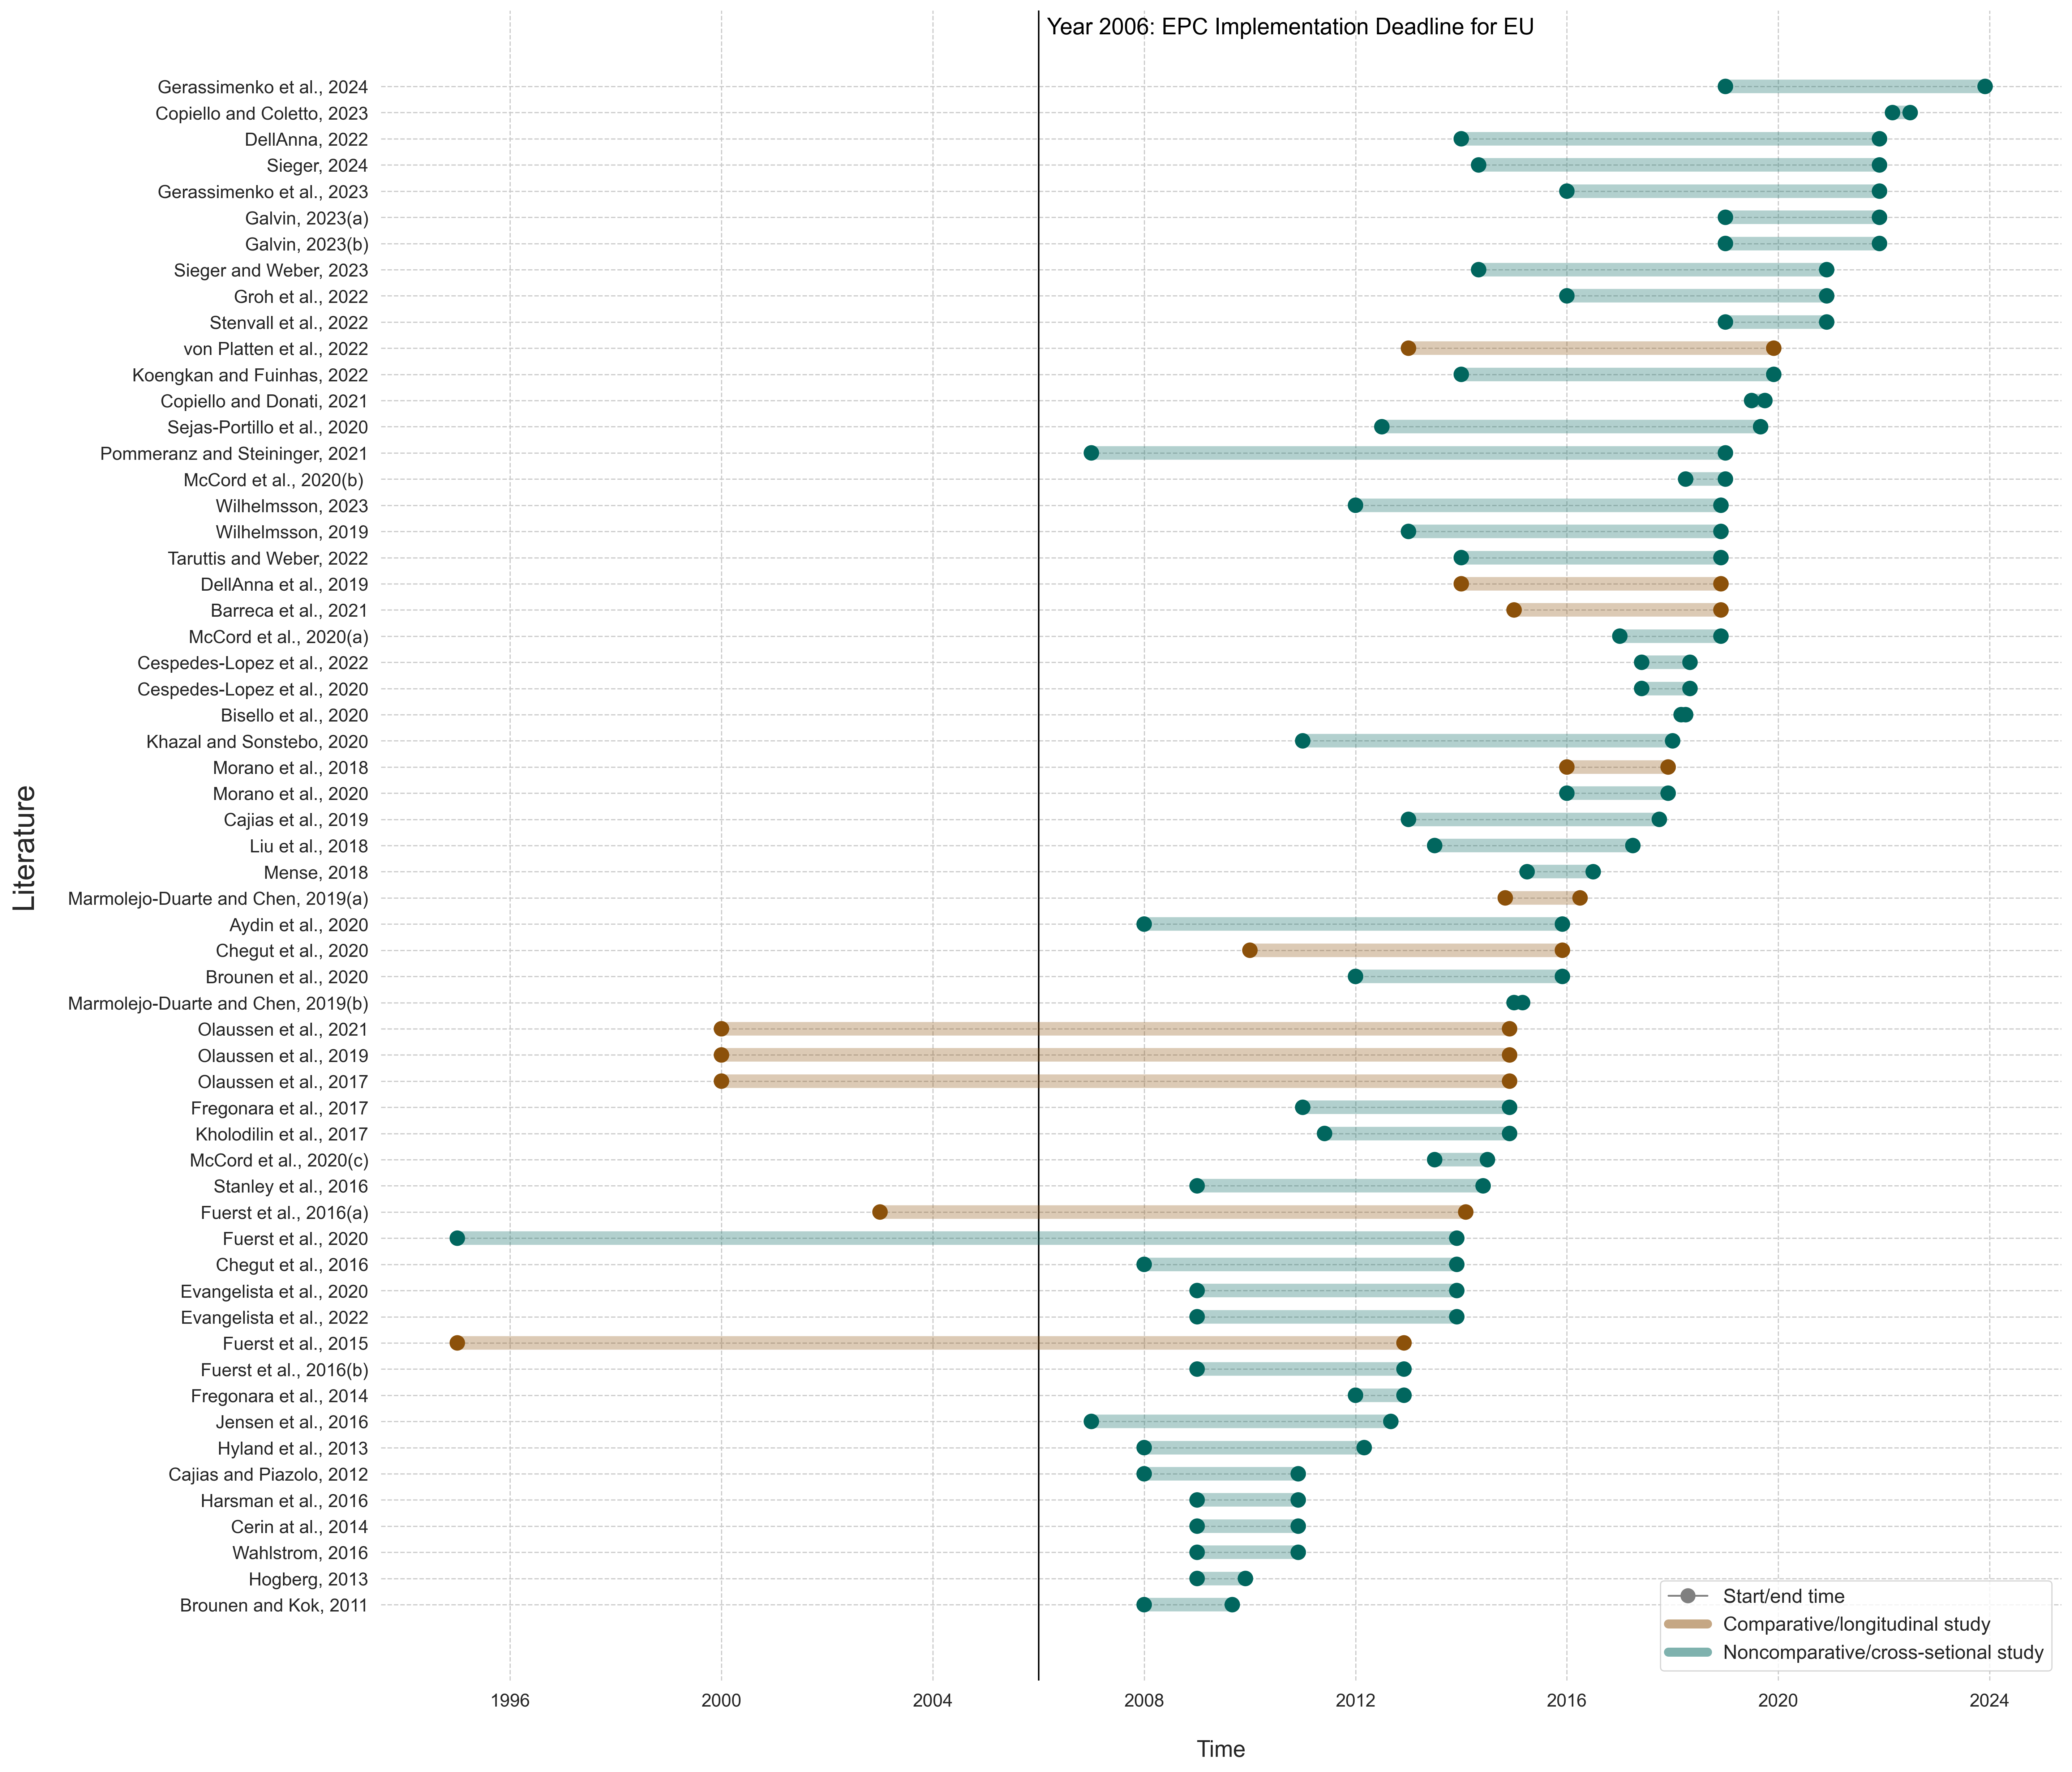

In [81]:
# Lolipop chart
palette = ['#01665e','#5ab4ac','#c7eae5','#f7f7f7','#f6e8c3','#d8b365','#8c510a']

plt.figure(figsize=(20,20),dpi=300)
sns.set_style('whitegrid',{'grid.linestyle':'--'})
lit_range = range(1,len(inventory_lolipop.index)+1)

# set color
lit_color=np.where((inventory_lolipop['rd_2']!='Cross-sectional') | (inventory_lolipop['rd_1']=='Observational - comparative'),
                   '#8c510a','#01665e')

# scatter and line
ax = plt.axes(frameon=False)
plt.hlines(y=lit_range,xmin=inventory_lolipop['time_start'], xmax=inventory_lolipop['time_end'],
           color=lit_color,lw=9,zorder=2,alpha=0.3)
plt.scatter(inventory_lolipop['time_start'],lit_range,color=lit_color,
            s=90,zorder=3)
plt.scatter(inventory_lolipop['time_end'],lit_range,color=lit_color,
            s=90,zorder=3)

# vertical line for EPC policy
plt.axvline(x=pd.to_datetime('200601',format='%Y%m'), color='black',lw=1,zorder=1)
plt.text(x=pd.to_datetime('200603',format='%Y%m'),y=61,s='Year 2006: EPC Implementation Deadline for EU',
         fontsize=15,color='black')

# create the legend
legend_elements = [Line2D([0], [0], marker='o', color='grey', label='Start/end time',
                          markerfacecolor='grey', markersize=9),
                          Line2D([0], [0], color='#8c510a', lw=6, label='Comparative/longitudinal study',alpha=0.5),
                          Line2D([0], [0], color='#01665e', lw=6, label='Noncomparative/cross-setional study',alpha=0.5)]
ax.legend(handles=legend_elements, loc='lower right',fontsize=13)

# set legend and ticks
plt.xlabel('Time', fontsize=15,labelpad=20)
plt.ylabel('Literature',fontsize=20,labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(lit_range, inventory_lolipop['reference'],fontsize=12)

# save figure
plt.savefig('03figures/Figure_3.png',bbox_inches='tight')
plt.show()

# 4. Research method

In [82]:
# 1. Variables for research method
model_cat_var = ['meth_model', 'meth_loc', 'meth_tem', 'meth_spatial_inter', 'functional_form', 'var_structural','var_neighborhood','var_quality']

In [83]:
# 2. Frequency of research methods
for var in model_cat_var:
    print(db_models[var].value_counts())

meth_model
OLS      68
QR       13
SEM       7
SLM       4
EPR       4
GWR       3
SAR       3
RDD       2
MLR       2
GAM       2
OR        1
ANOVA     1
RF        1
Name: count, dtype: int64
meth_loc
Yes    87
No     24
Name: count, dtype: int64
meth_tem
Yes    59
No     52
Name: count, dtype: int64
meth_spatial_inter
No     94
Yes    17
Name: count, dtype: int64
functional_form
semi-log          80
log-log           17
linear            13
not applicable     1
Name: count, dtype: int64
var_structural
Yes    110
No       1
Name: count, dtype: int64
var_neighborhood
No     61
Yes    50
Name: count, dtype: int64
var_quality
No     68
Yes    43
Name: count, dtype: int64


In [84]:
db_studies.columns

Index(['paper_id', 'source', 'reference', 'DOI', 'gen_title', 'gen_pub_year',
       'gen_publisher', 'geog_country', 'geog_scale', 'time_start', 'time_end',
       'time_span', 'rd_1', 'rd_2', 'data_sample_size', 'data_ht_1',
       'data_ht_2', 'data_pt', 'data_tenure', 'var_ee_aspect', 'var_ee_scale',
       'var_ee_time', 'meth_cat', 'res_broad', 'time_span_cal',
       'time_span_cat'],
      dtype='object')

In [85]:
# 3. Change of research methods along time
db_studies['gen_pub_year'] = pd.to_datetime(db_studies['gen_pub_year'],format='%Y')

# add a column to aggregate publication time
db_studies['Published time'] = db_studies['gen_pub_year'].apply(lambda x: 'After 2020' if 
                                                                    x>=pd.to_datetime('202001',format='%Y%m') else 
                                                                    'Before 2020')


In [86]:
db_studies['Published time'].value_counts()

Published time
After 2020     37
Before 2020    31
Name: count, dtype: int64

In [87]:
db_studies.groupby(['Published time'])['meth_cat'].value_counts()

Published time  meth_cat           
After 2020      OLS                    15
                Advanced regression     7
                Spatial regression      7
                Linear extension        5
                ANOVA and OLS           1
                OLS and RDD             1
                Random forest           1
Before 2020     OLS                    24
                Spatial regression      4
                Advanced regression     2
                Linear extension        1
Name: count, dtype: int64

# 5. Research outcome

## 5.1 Define groups

In [88]:
# 1. Add column for north/south europe
cli_seurope = ['Portugal','Spain','Italy','Romania','Spain and Italy']
cli_neurope = ['Norway', 'Sweden', 'Finland', 'United Kingdom', 'Ireland', 'Netherlands', 'Denmark', 'Germany',
               'Belgium','United Kingdom and Netherlands']

db_models['europez'] = db_models['geog_country'].apply(lambda x: 'Southern Europe' if x in cli_seurope else 'Northern/western Europe')
db_studies['europez'] = db_studies['geog_country'].apply(lambda x: 'Southern Europe' if x in cli_seurope else 'Northern/western Europe')

In [89]:
# 2. Add column for  time group
# if data end time b/a 2016
db_models['time_end_b/a2016'] = db_models['time_end'].apply(lambda x: 'After 2016' if 
                                                                    x>=pd.to_datetime('201601',format='%Y%m') else 
                                                                    'Before 2016')
db_studies['time_end_b/a2016'] = db_studies['time_end'].apply(lambda x: 'After 2016' if 
                                                                    x>=pd.to_datetime('201601',format='%Y%m') else 
                                                                    'Before 2016')

## 5.2 Broad outcome

In [90]:
# 1. Frequency of broad research outcome
db_studies['res_broad'].value_counts()

res_broad
positive     51
no impact    12
depends       5
Name: count, dtype: int64

In [91]:
# 2. Difference between south/north europe
db_studies.groupby('europez')['res_broad'].value_counts()

europez                  res_broad
Northern/western Europe  positive     32
                         no impact     6
                         depends       5
Southern Europe          positive     19
                         no impact     6
Name: count, dtype: int64

In [92]:
# 3. Difference between publication time
db_studies['gen_pub_year_cal'] = db_studies['gen_pub_year'].apply(lambda x: 'After 2016' if x>=pd.to_datetime('201601',format='%Y%m') else 'Before 2016')
db_studies.groupby('gen_pub_year_cal')['res_broad'].value_counts()

gen_pub_year_cal  res_broad
After 2016        positive     45
                  no impact    11
                  depends       4
Before 2016       positive      6
                  depends       1
                  no impact     1
Name: count, dtype: int64

In [93]:
# 4. Chi square test - geography
ct_table=pd.crosstab(db_studies["europez"],db_studies["res_broad"])

chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table)

print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     3.8164
p-value:            0.14834
degrees of freedom: 2
expected frequencies:
 [[ 3.16176471  7.58823529 32.25      ]
 [ 1.83823529  4.41176471 18.75      ]]


In [94]:
# 5. Chi square test - time
ct_table=pd.crosstab(db_studies["time_end_b/a2016"],db_studies["res_broad"])

chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     4.1055
p-value:            0.12838
degrees of freedom: 2
expected frequencies:
 [[ 2.57352941  6.17647059 26.25      ]
 [ 2.42647059  5.82352941 24.75      ]]


## 5.3 Price premium

### 5.3.1 Filter models

In [95]:
# 1. Filter models that follow the hedonic approach with EER rating
pp_hedonic = db_models[(db_models['diff_pp_flag']==0) & (db_models['diff_rd_flag']==0)
                       & (db_models['var_ee_aspect']=='EER') & (db_models['var_ee_scale']=='Band')
                       & (db_models['functional_form']=='semi-log')]

In [96]:
# number of models
pp_hedonic.shape

(38, 49)

In [97]:
# number of studies
pp_hedonic['paper_id'].unique().shape

(28,)

### 5.3.2 Preprocess coefficients

In [98]:
# 1. Preprocess coefficients
# define function to preprocess price premium
def pp_rating_preprocess(pp_hedonic):
    pp_hedonic_coeff = pp_hedonic[['pp_band_a','pp_band_b','pp_band_c','pp_band_d','pp_band_e',
            'pp_band_f','pp_band_g']]
    
    # data cleaning
    pp_hedonic_coeff_clean = pp_hedonic_coeff.replace('not mentioned',np.nan)
    pp_hedonic_coeff_clean = pp_hedonic_coeff_clean.replace('hold-out',0)
    pp_hedonic_coeff_clean = pp_hedonic_coeff_clean.replace(np.nan,100)

    # change dtype to float
    pp_hedonic_coeff_clean = pp_hedonic_coeff_clean.astype('float')

    # change '100' to nan
    for column in pp_hedonic_coeff_clean.columns:
        pp_hedonic_coeff_clean[column] = pp_hedonic_coeff_clean[column].apply(lambda x: np.nan if int(x)==100 else x)

    # taking band d as reference
    pp_hedonic_coeff_clean_cal = pp_hedonic_coeff_clean.copy(deep=True)
    for column in pp_hedonic_coeff_clean.columns:
        pp_hedonic_coeff_clean_cal[column] = pp_hedonic_coeff_clean[column] - pp_hedonic_coeff_clean['pp_band_d']
    
    return pp_hedonic_coeff_clean_cal

In [99]:
# set model_id as index
pp_hedonic = pp_hedonic.set_index('model_id')

In [100]:
# calculate coefficients
pp_hedonic_coeff = pp_rating_preprocess(pp_hedonic)

In [101]:
# 2. Count missing coefficients in each column (for each EPC band)
pp_nan_count = pp_hedonic_coeff.isna().sum()
pp_nan_count.to_frame()

,0
pp_band_a,6
pp_band_b,3
pp_band_c,1
pp_band_d,1
pp_band_e,1
pp_band_f,1
pp_band_g,3


### 5.3.3 Synthesis

In [102]:
# 1. Average price premium 
pp_hedonic_coeff.apply(np.mean,axis=0)

pp_band_a    0.082178
pp_band_b    0.059757
pp_band_c    0.021068
pp_band_d    0.000000
pp_band_e   -0.019719
pp_band_f   -0.036527
pp_band_g   -0.049251
dtype: float64

In [103]:
# 2. Median price premium
pp_hedonic_coeff.apply(np.nanmedian,axis=0)

pp_band_a    0.061
pp_band_b    0.045
pp_band_c    0.014
pp_band_d    0.000
pp_band_e   -0.010
pp_band_f   -0.026
pp_band_g   -0.035
dtype: float64

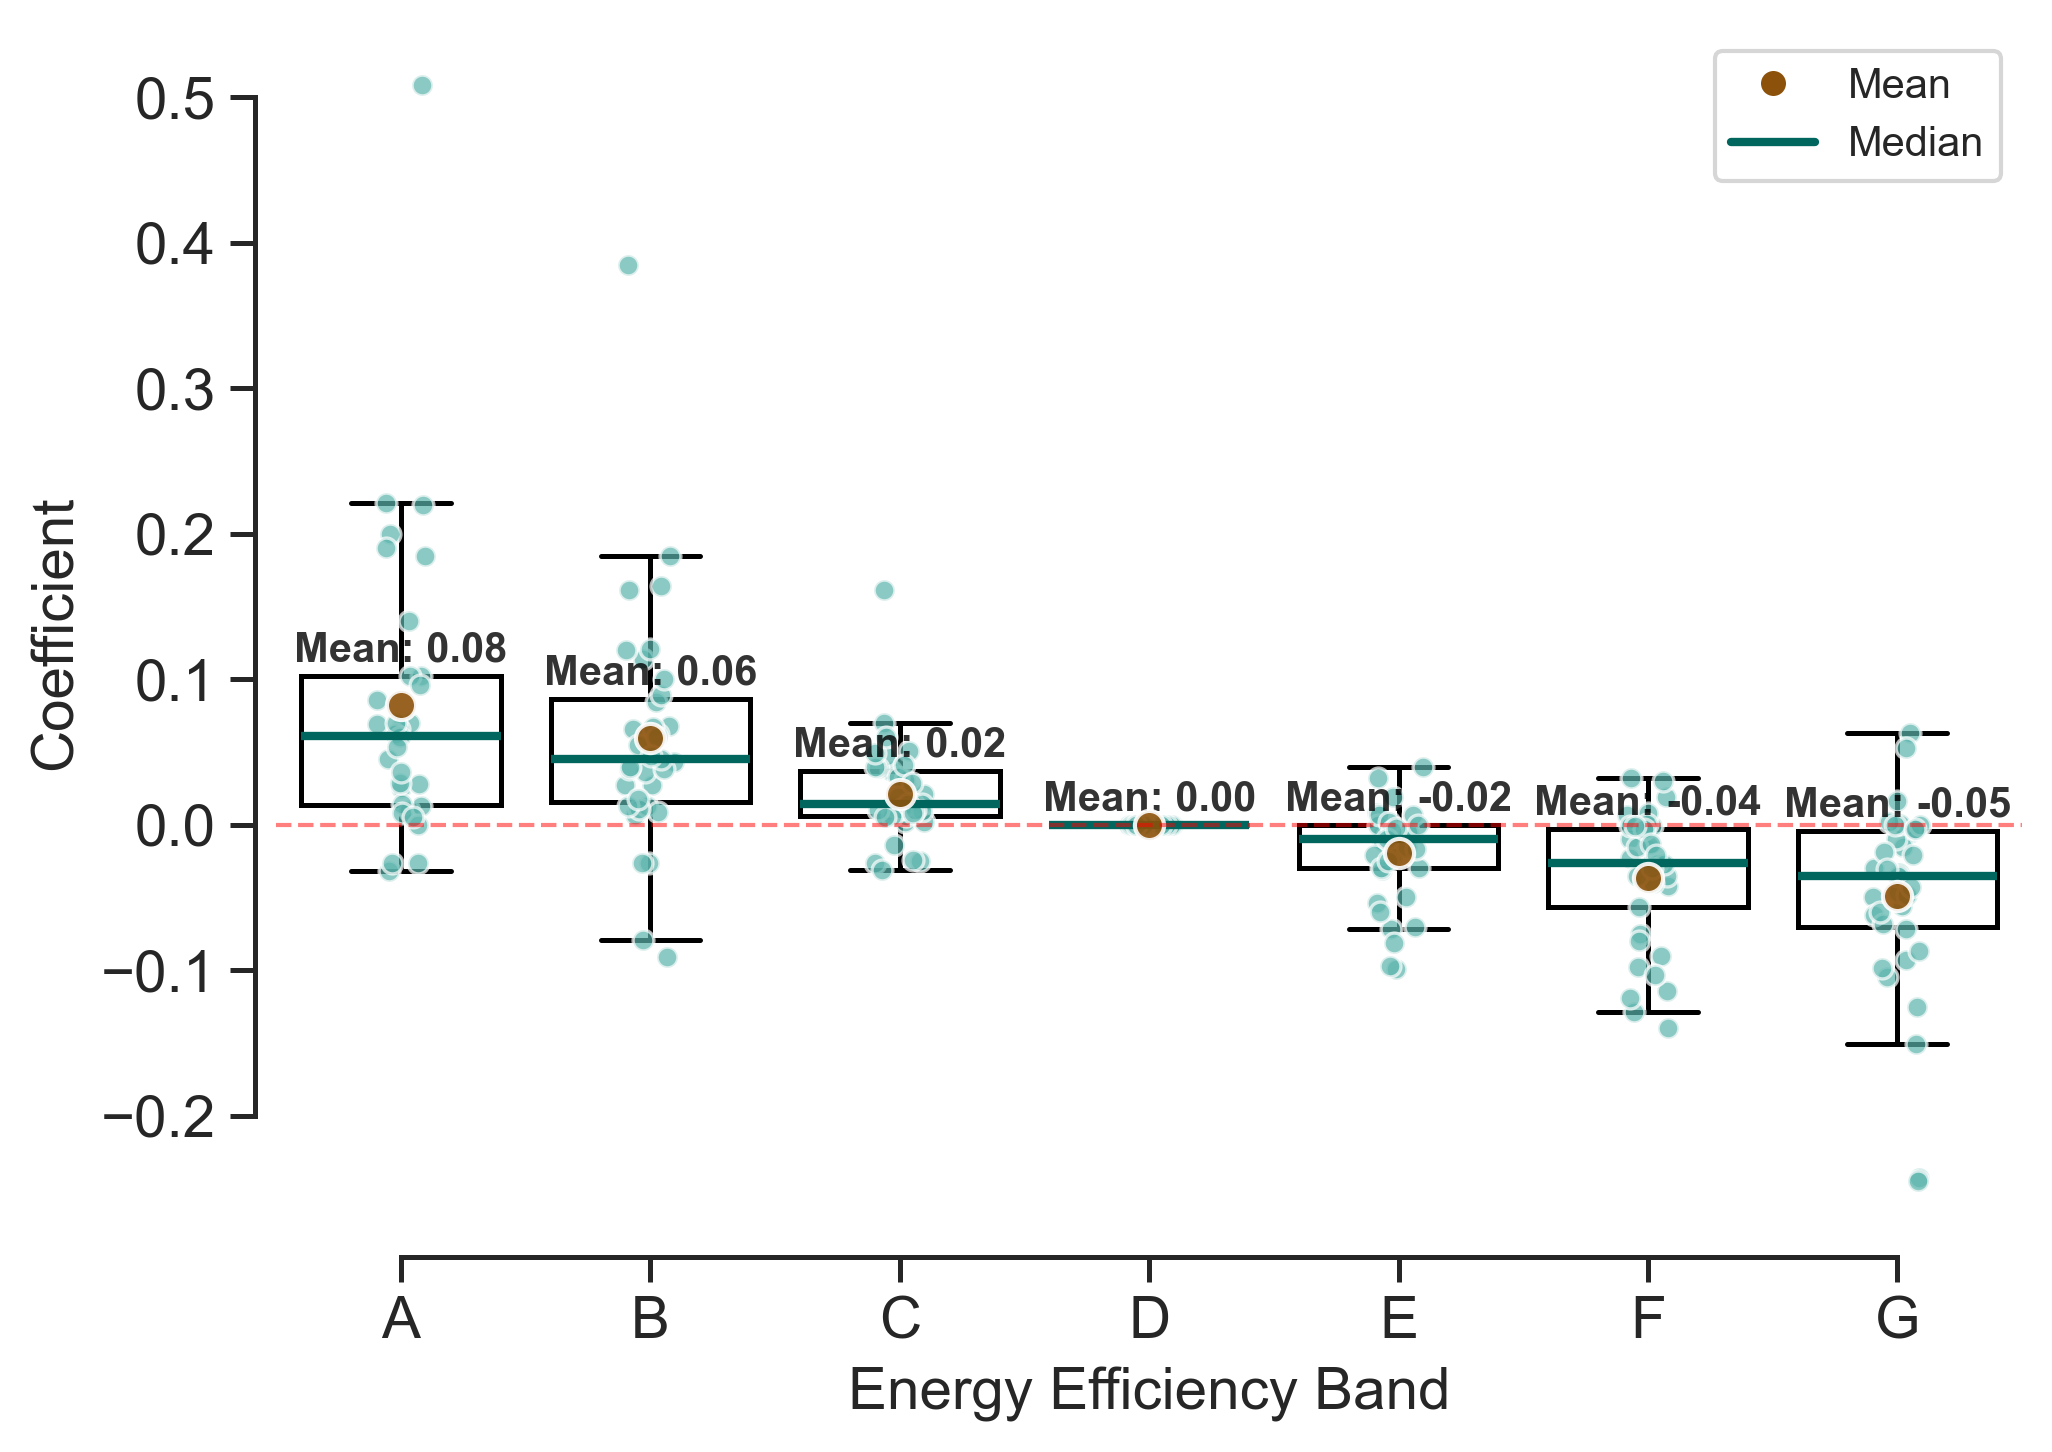

In [108]:
# 3. Visualise distribution of price premium
df = pp_hedonic_coeff

fig, ax = plt.subplots(figsize=(7, 5),dpi=300)

# pre settings
palette = ['#01665e','#5ab4ac','#c7eae5','#f7f7f7','#f6e8c3','#d8b365','#8c510a']
sns.set_context("paper", font_scale=1.6) 

sns.set_theme(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (6, 10),      # width = 6, height = 9
            "figure.facecolor": "white",  # Figure colour
            "axes.facecolor": "white"}) 

# boxplot
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'#01665e','linewidth':2},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'meanprops':{'marker':'o',
    'markerfacecolor':'#8c510a', 
    'markeredgecolor':'white',
    'linewidth': 1,
    'markersize':'7',
    'alpha':.9}
}

box_plot=sns.boxplot(data=df, showfliers=False, linewidth=1.2, ax=ax,showmeans=True, zorder=3, **PROPS)

# striplot
strip_plot=sns.stripplot(data =df, size=5, color = "#5ab4ac", linewidth = 0.8, edgecolor="white", alpha = .7, label='points')

# annotate mean
means = df.mean().tolist()
uppers = df.quantile(q=0.75).tolist()

# draw horizonal line for y=0
ax.axhline(0, color='red',lw=1,zorder=4,alpha=.5,linestyle='--')
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,uppers[xtick]+0.01,'Mean: {:.2f}'.format(means[xtick]), 
            horizontalalignment='center',size=10,color='black',weight='semibold',zorder=3,alpha=.8)

# set axis linewidth
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.tick_params(width=1.2)

# set labels/ticks
ax.set_xlabel('Energy Efficiency Band',fontsize=14)
ax.set_ylabel('Coefficient',fontsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['A', 'B', 'C', 'D', 'E', 'F', 'G'],fontsize=14)

# removw top and right spines
sns.despine(offset = 5, trim = True)

# create the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#8c510a', markersize=7, label='Mean'), Line2D([0], [0], color='#01665e', lw=2, label='Median')]
ax.legend(handles=legend_elements, loc='upper right',fontsize=10)

# save figure 
fig.tight_layout()
plt.savefig('03figures/Figure_4.png',bbox_inches='tight')
plt.show()

### 5.3.4 Submarket synthesis

In [158]:
pp_hedonic_coeff = pp_hedonic_coeff.rename(columns={'pp_band_a': 'A','pp_band_b':'B','pp_band_c':'C','pp_band_d':'D',
                                                    'pp_band_e':'E','pp_band_f':'F','pp_band_g':'G'}, errors="raise")

In [159]:
# 1. Long foramt dataframe for geography 
geog_var = 'europez'
pp_hedonic_climate = pp_hedonic_coeff.merge(pp_hedonic[geog_var],left_index=True, right_index=True, how='left')

print(pp_hedonic_climate[geog_var].value_counts())

pp_hedonic_climate = pp_hedonic_climate.rename(columns={geog_var: "Geographical region"}, errors="raise")

# transform dataframe to long format for boxplot
pp_hedonic_climate = pd.melt(pp_hedonic_climate, id_vars=['Geographical region'], value_vars=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

pp_hedonic_climate = pp_hedonic_climate.rename(columns={'variable': "Energy Efficiency Band",'value': 'Coefficient'}, errors="raise")

europez
Northern/western Europe    22
Southern Europe            16
Name: count, dtype: int64


In [160]:
# 2. Long foramt dataframe for time
time_var = 'time_end_b/a2016'
pp_hedonic_time = pp_hedonic_coeff.merge(pp_hedonic[time_var],left_index=True, right_index=True, how='left')

print(pp_hedonic_time[time_var].value_counts())

pp_hedonic_time = pp_hedonic_time.rename(columns={time_var: "Time period"}, errors="raise")

# transform dataframe to long format for boxplot
pp_hedonic_time = pd.melt(pp_hedonic_time, id_vars=['Time period'], value_vars=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

pp_hedonic_time = pp_hedonic_time.rename(columns={'variable': "Energy Efficiency Band",'value': 'Coefficient'}, errors="raise")

time_end_b/a2016
Before 2016    26
After 2016     12
Name: count, dtype: int64


In [161]:
# 3. Long foramt dataframe for dwelling type
del_var = 'data_ht_1' 
pp_hedonic_del = pp_hedonic_coeff.merge(pp_hedonic[del_var],left_index=True, right_index=True, how='left')

print(pp_hedonic_del[del_var].value_counts())

pp_hedonic_del = pp_hedonic_del.rename(columns={del_var: "Dwelling type"}, errors="raise")

# transform dataframe to long format for boxplot
pp_hedonic_del = pd.melt(pp_hedonic_del, id_vars=["Dwelling type"], value_vars=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

pp_hedonic_del = pp_hedonic_del.rename(columns={'variable': "Energy Efficiency Band",'value': 'Coefficient'}, errors="raise")

data_ht_1
All          21
Apartment    13
House         4
Name: count, dtype: int64


In [162]:
# 4. Long foramt dataframe for tenure type
ten_var = 'data_tenure'
pp_hedonic_ten = pp_hedonic_coeff.merge(pp_hedonic[ten_var],left_index=True, right_index=True, how='left')

print(pp_hedonic_ten[ten_var].value_counts())

pp_hedonic_ten = pp_hedonic_ten.rename(columns={ten_var: "Tenure"}, errors="raise")

# transform dataframe to long format for boxplot
pp_hedonic_ten = pd.melt(pp_hedonic_ten, id_vars=['Tenure'], value_vars=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

pp_hedonic_ten = pp_hedonic_ten.rename(columns={'variable': "Energy Efficiency Band",'value': 'Coefficient'}, errors="raise")

data_tenure
Sales    30
Rents     8
Name: count, dtype: int64


C:\Users\2702471O\AppData\Local\Temp\ipykernel_13484\3832370280.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=pp_hedonic_climate, x=variable, y=value, hue="Geographical region",palette=palette, ax=axes[0,0],showfliers = False,showmeans=True,
C:\Users\2702471O\AppData\Local\Temp\ipykernel_13484\3832370280.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=pp_hedonic_time, x=variable, y=value, hue="Time period",palette=palette, ax=axes[0,1],showfliers = False,showmeans=True,
C:\Users\2702471O\AppData\Local\Temp\ipykernel_13484\3832370280.py:30: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=pp_hedonic_ten, x=variable, y=value, hue="Tenure",palette=palette, ax=axes[1,1],showfliers = False,showmeans=True,


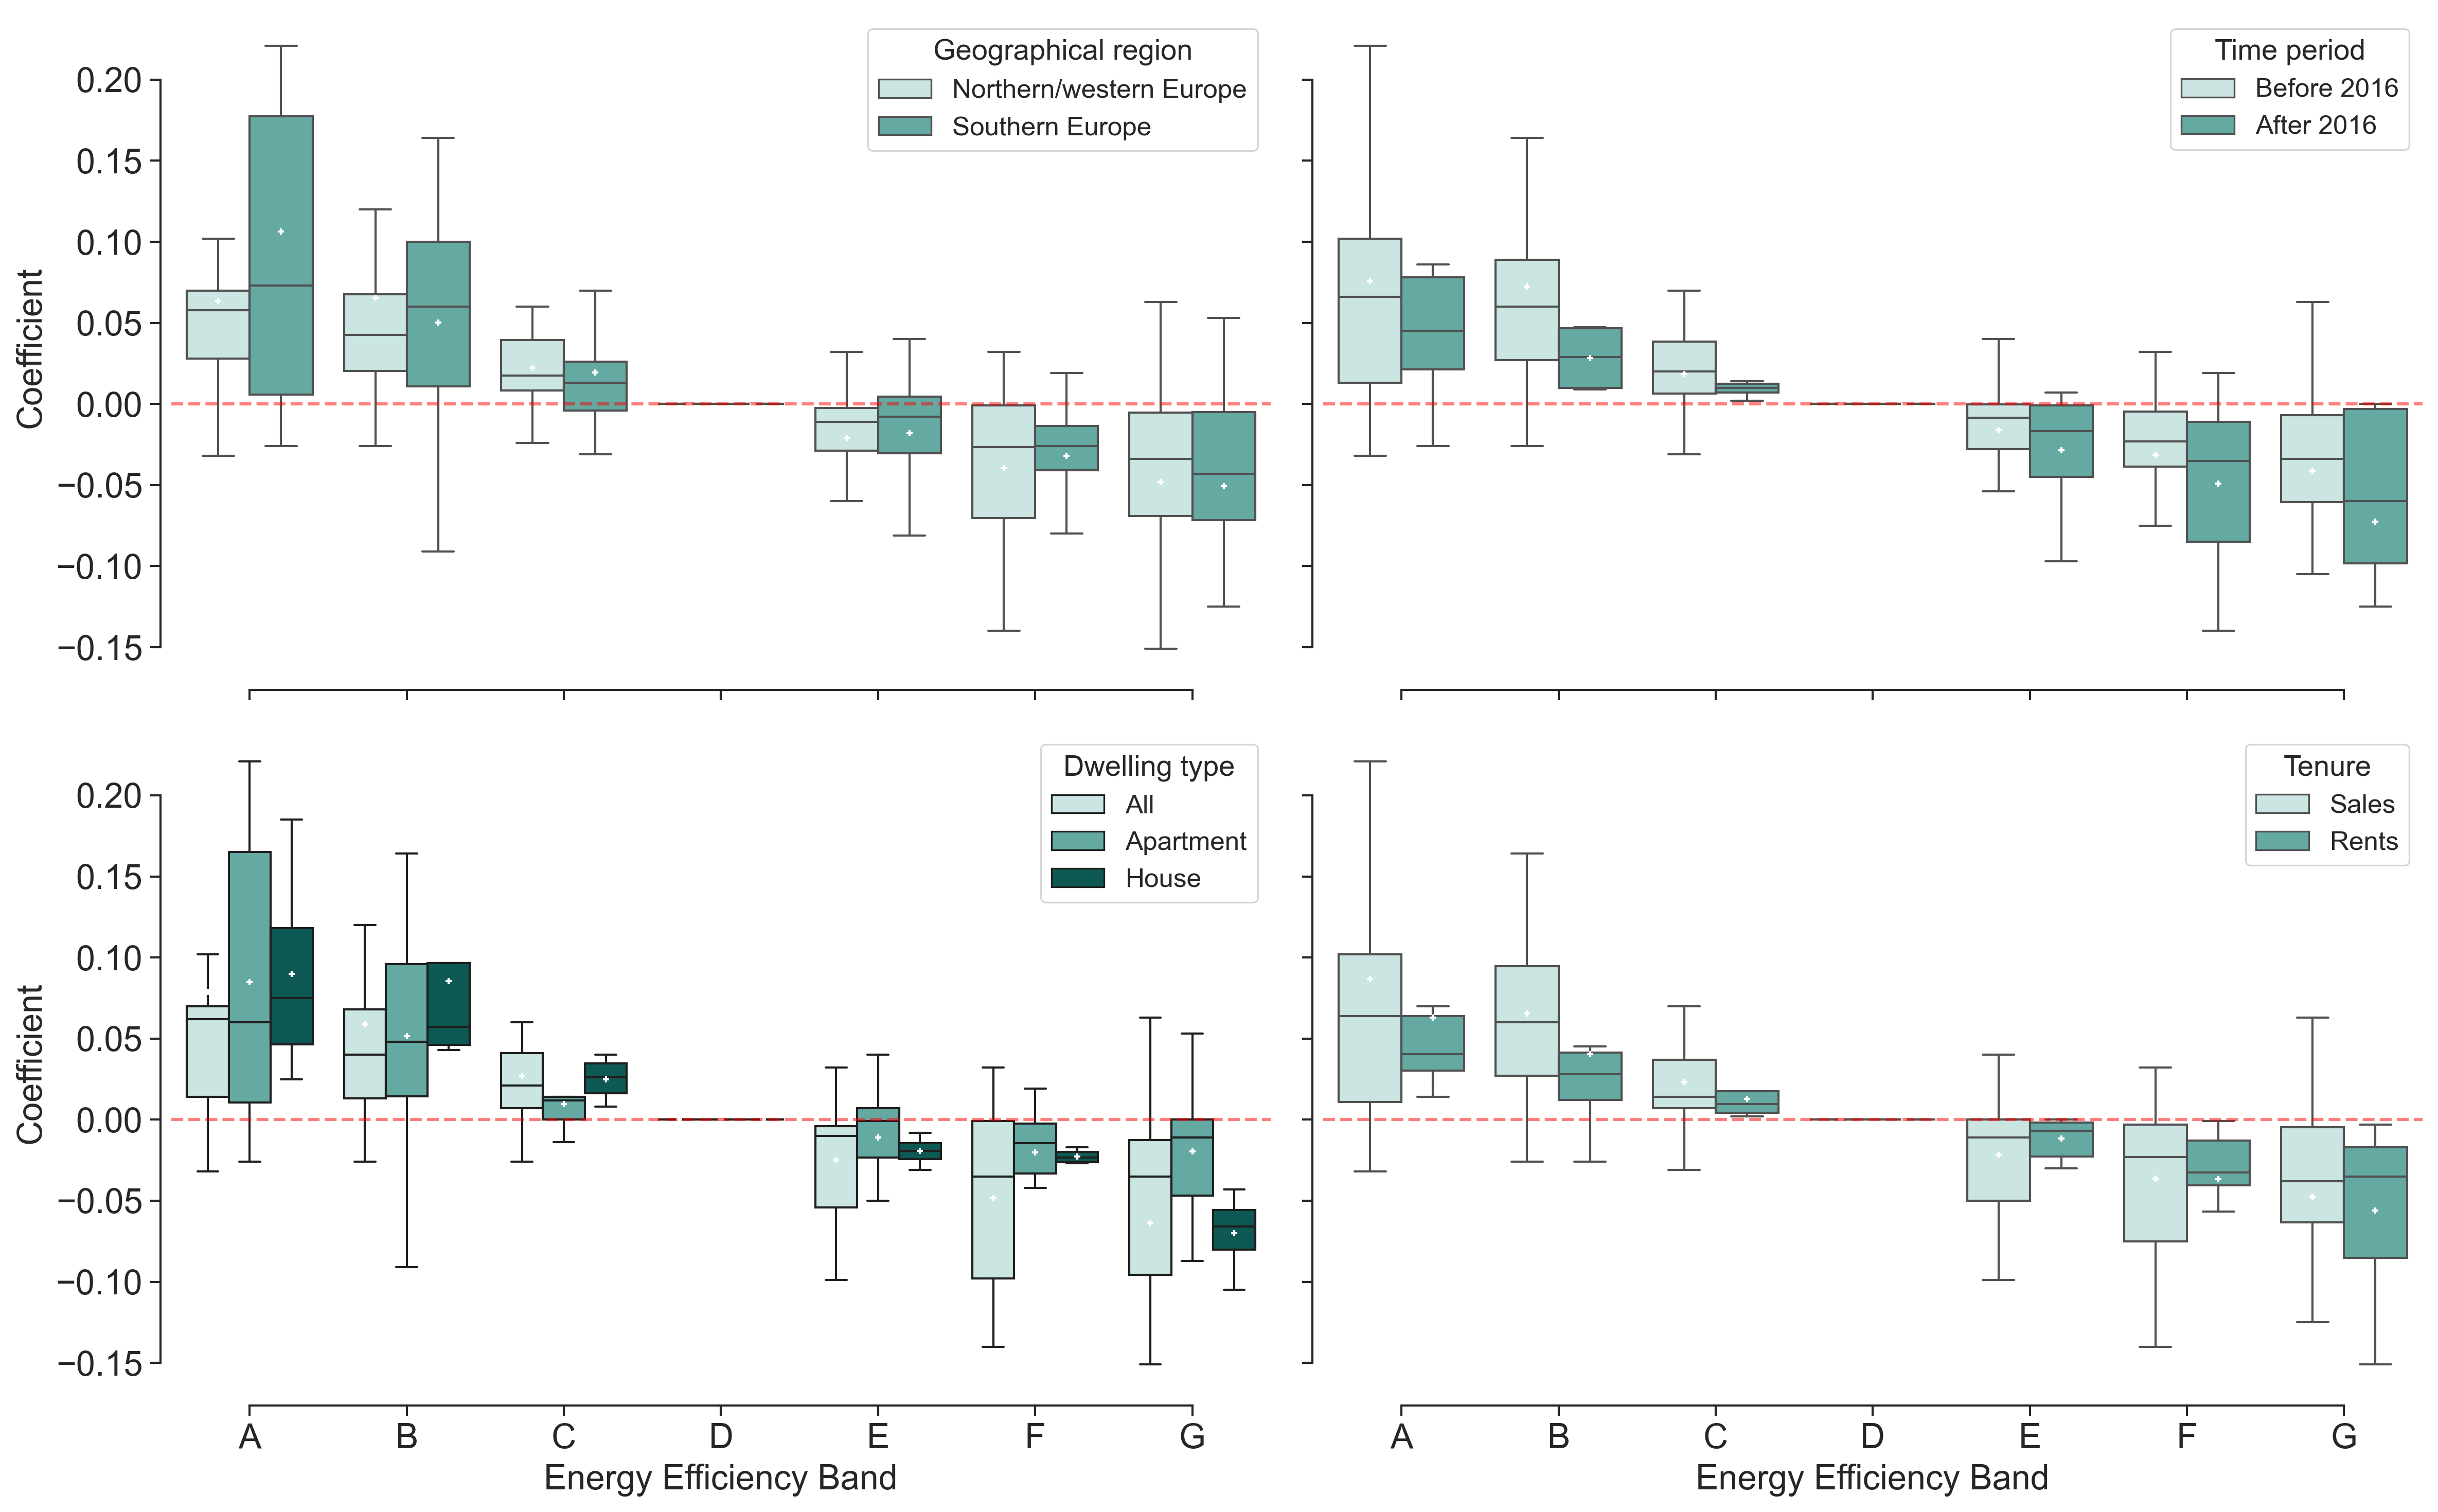

In [176]:
# 5. Visualisation
fig, axes= plt.subplots(nrows=2,ncols=2,figsize=(16, 10),dpi=300,sharey=True,sharex=True)

variable= 'Energy Efficiency Band'
value='Coefficient'

palette = ['#c7eae5','#5ab4ac', '#01665e']
sns.set_context("paper", font_scale=1.4) 

# ax1
# boxplot
sns.boxplot(data=pp_hedonic_climate, x=variable, y=value, hue="Geographical region",palette=palette, ax=axes[0,0],showfliers = False,showmeans=True,
                     meanprops={'marker':'+', 'markeredgecolor':'white', 'markersize':'3'},zorder=2)
axes[0,0].axhline(0, color='red',lw=1.5,zorder=4,alpha=.5,linestyle='--')

# ax2
# boxplot
sns.boxplot(data=pp_hedonic_time, x=variable, y=value, hue="Time period",palette=palette, ax=axes[0,1],showfliers = False,showmeans=True,
                     meanprops={'marker':'+', 'markeredgecolor':'white', 'markersize':'3'},zorder=2)
axes[0,1].axhline(0, color='red',lw=1.5,zorder=4,alpha=.5,linestyle='--')

# ax3
# boxplot
sns.boxplot(data=pp_hedonic_del, x=variable, y=value, hue="Dwelling type",palette=palette, ax=axes[1,0],showfliers = False,showmeans=True,
                     meanprops={'marker':'+', 'markeredgecolor':'white', 'markersize':'3'},zorder=2)
axes[1,0].axhline(0, color='red',lw=1.5,zorder=4,alpha=.5,linestyle='--')

# ax4
# boxplot
sns.boxplot(data=pp_hedonic_ten, x=variable, y=value, hue="Tenure",palette=palette, ax=axes[1,1],showfliers = False,showmeans=True,
                     meanprops={'marker':'+', 'markeredgecolor':'white', 'markersize':'3'},zorder=2)
axes[1,1].axhline(0, color='red',lw=1.5,zorder=4,alpha=.5,linestyle='--')

# remove plot boundary
sns.despine(offset = 5, trim = True)

for ax in axes.flat:
    # Set tick font sizes
    ax.tick_params(axis='both', labelsize=16)  # Changes font size for both x and y ticks
    
    # Set axis label font sizes
    ax.set_xlabel('Energy Efficiency Band', fontsize=16)  # Set x-axis label font size
    ax.set_ylabel('Coefficient', fontsize=16)  # Set y-axis label font size

# save figure
fig.tight_layout()
plt.savefig('03figures/Figure_5.png',bbox_inches='tight')
plt.show()

### 5.3.5 Other synthesis

#### (1) EER score

In [177]:
# 1. hedonic approach for energy score
pp_hedonic_score = db_models[(db_models['diff_pp_flag']==0) & (db_models['diff_rd_flag']==0)
                       & (db_models['var_ee_aspect']=='EER') & (db_models['var_ee_scale']=='Score')
                       & (db_models['functional_form']=='semi-log')]

In [178]:
pp_hedonic_score.shape

(3, 49)

In [179]:
pp_hedonic_score['pp_score'] = pp_hedonic_score['pp_score'].astype('float')

C:\Users\2702471O\AppData\Local\Temp\ipykernel_13484\1486746180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_hedonic_score['pp_score'] = pp_hedonic_score['pp_score'].astype('float')


In [180]:
pp_hedonic_score[['paper_id','pp_score']]

,paper_id,pp_score
0,1,0.0023
1,1,0.0012
58,31,0.0040


In [181]:
np.mean(pp_hedonic_score['pp_score'])

0.0025

#### (2) EPI (kWh/m2/year)

In [182]:
# 2. hedonic approach for energy consumption
pp_hedonic_econsumption = db_models[(db_models['diff_rd_flag']==0)
                       & (db_models['var_ee_aspect']=='EER') & (db_models['var_ee_scale']=='Energy consumption')
                       & (db_models['functional_form']=='semi-log')]

In [183]:
pp_hedonic_econsumption.shape

(6, 49)

In [184]:
pp_hedonic_econsumption['pp_other'] = pp_hedonic_econsumption['pp_other'].astype('float')
np.mean(pp_hedonic_econsumption['pp_other'])

C:\Users\2702471O\AppData\Local\Temp\ipykernel_13484\2659437947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_hedonic_econsumption['pp_other'] = pp_hedonic_econsumption['pp_other'].astype('float')


-0.01674166666666667

In [185]:
pp_hedonic_econsumption['pp_other']

39    -0.06270
78    -0.04400
81    -0.00050
82    -0.00020
87    -0.00075
103    0.00770
Name: pp_other, dtype: float64